In [7]:
#Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import scipy.stats as stats
import ast
from scipy.stats import invgamma,loggamma,invgauss
import matplotlib.patches as mpatches
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns

!pip install openpyxl


"""Données"""
#EMP=pd.read_csv("https://raw.githubusercontent.com/kilianguillon/Projet_statapp/main/data/EMP_deplacements_Charme.csv", sep=";", encoding='latin-1')
EMP=pd.read_excel("data/data.xlsx")
EMP["HEURE_ARRIVEE"]=EMP["HEURE_ARRIVEE"].replace(',', '.', regex=True).astype(float)


#Lire le tableau des lois de durée restée dans un lieu:
tableau_duree= pd.read_excel("data/lois_duree.xlsx")
tableau_duree=tableau_duree.set_index("Unnamed: 0").rename_axis("Plage horaire")
tableau_duree=tableau_duree.map(lambda x: ast.literal_eval(x))

#On crée les plages horraires :

EMP.loc[EMP["HEURE_ARRIVEE"].between(0, 11),"Plage_horraire"] = "00-11h"
EMP.loc[EMP["HEURE_ARRIVEE"].between(11, 14),"Plage_horraire"] = "11-14h"
EMP.loc[EMP["HEURE_ARRIVEE"].between(14, 17),"Plage_horraire"] = "14-17h"
EMP.loc[EMP["HEURE_ARRIVEE"].between(17, 24),"Plage_horraire"] = "17-00h"






"""Fonctions"""

def count_occ_pond(data, nom_var, nom_pond, taille=10):
    value = data[nom_var].unique() #cette fonction est utile pour des variables prenant un nbre de valeurs finies
    result_dict = {nom_var: [], 'Occurences pondérées': [], 'Proportion':[]} #à chaque valeur on associe la somme des occurences pondérées
    N=data[nom_pond].replace(',', '.', regex=True).astype(float).sum()
    for val in value :
        somme_pond = data[data[nom_var] == val][nom_pond].replace(',', '.', regex=True).astype(float).sum() #replace car la base utilisée est "française"
        result_dict[nom_var].append(val)
        result_dict['Occurences pondérées'].append(somme_pond)
        result_dict['Proportion'].append(round(100*somme_pond/N,2))
    return pd.DataFrame(result_dict).sort_values('Occurences pondérées', ascending=False).reset_index(drop=True).head(taille)


#On définit une fonction qui selon les probabilités ci-dessus, va produire le lieu de départ de n individus
def loi_lieu_depart(n=1, p_domicile=70.49/100, p_rue=23.87/100, p_parking=3.90/100, p_entreprise=1.38/100, p_sans=0.36/100):
    matrice_initiale = [random.uniform(0, 1) for k in range(n)]
    for i in range(n):
        if matrice_initiale[i] <= p_domicile:
            matrice_initiale[i] = "Domicile"
        elif matrice_initiale[i] <= p_domicile + p_rue:
            matrice_initiale[i] = "Rue"
        elif matrice_initiale[i] <= p_domicile + p_rue + p_parking:
            matrice_initiale[i] = "Parking"
        elif matrice_initiale[i] <= p_domicile + p_rue + p_parking + p_entreprise:
            matrice_initiale[i] = "Entreprise"
        else:
            matrice_initiale[i] = "Sans"
    
    return matrice_initiale


#On va créer un e fonction liée à count_occ_pound qui pour chaque plage horraire va nous envoyer la proba de Lieu_Arrivee pour chaque Lieu_Depart
def transition_plage(plage):

    Lieux = ["Domicile","Rue","Entreprise","Parking","Sans"] 
    results=None
    for Lieu in Lieux:
        data = EMP[(EMP["Plage_horraire"] == plage) & (EMP["Lieu_Depart"] == Lieu)]
        results_temp = count_occ_pond(data, 'Lieu_Arrivee', 'POND_JOUR').iloc[:, [0, 2]]

        results_temp["Proportion"] = results_temp["Proportion"] / 100
        results_temp.rename(columns={'Proportion': 'Proba'+'_'+Lieu}, inplace=True)


        if results is None: #on fusionne toutes les proportions pour créer la matrice
            results = results_temp
        else:
            results = pd.merge(results, results_temp, on='Lieu_Arrivee')

    return results


#Maintenant on va créer une fonction à laquelle on donne un lieu de départ et une heure de départ et qui nous donne un lieu d'arrivée
#En suivant les proba obtenues ci-dessus
def calcul_lieu_arrivee(lieu_depart, heure_depart): #juste l'heure, les minutes ne sont pas utiles
    if heure_depart<11: #on trouve la plage horraire correspondante
        plage="00-11h"
    elif heure_depart<14 :
        plage="11-14h"
    elif heure_depart<17 :
        plage="14-17h"
    else:
        plage="17-00h"

    table=transition_plage(plage)[["Lieu_Arrivee", "Proba_"+lieu_depart]] #on prend les proba de déplacement pour cette plage et ce lieu de départ
    
    proba_parking = table.loc[table["Lieu_Arrivee"] == "Parking"].iloc[0,1]#proba d'aller dans un parking selon l'heure et le lieu de départ donnés.
    proba_domicile = table.loc[table["Lieu_Arrivee"] == "Domicile"].iloc[0,1]
    proba_rue = table.loc[table["Lieu_Arrivee"] == "Rue"].iloc[0,1]
    proba_entreprise = table.loc[table["Lieu_Arrivee"] == "Entreprise"].iloc[0,1]
    proba_sans = table.loc[table["Lieu_Arrivee"] == "Sans"].iloc[0,1]
    
    tirage=random.uniform(0, 1) #on construit la loi avec les probas obtenues
    if tirage < proba_parking:
        Lieu_Arrivee="Parking"
    elif tirage < proba_parking + proba_domicile:
        Lieu_Arrivee="Domicile"
    elif tirage < proba_parking + proba_domicile + proba_rue:
        Lieu_Arrivee="Rue"
    elif tirage < proba_parking + proba_domicile + proba_rue + proba_entreprise:
        Lieu_Arrivee="Entreprise"
    else:
        Lieu_Arrivee="Sans"
    
    return Lieu_Arrivee

#Fonction durée restée dans un lieu: prend une heure d'arrivée en format numérique et un lieu et renvoie une durée
def duree_lieu(heure_arrivee,lieu_arrivee):
    i=0
    while i==0:
        if heure_arrivee<=11:
            plage= "Matin"
        elif heure_arrivee<=14:
            plage="Midi"
        elif heure_arrivee<=17:
            plage= "Après-midi"
        else:
            plage= "Soir"
        loi=tableau_duree.loc[plage,lieu_arrivee]
        dist=loi[0]
        #print(dist)
        param=list(loi[1])
        if abs(param[-2])<10**(-2):
            param[-2]=0
        #print(param)
        sample = getattr(stats,dist).rvs(*param)
        if sample>=0:
            i=1
    return round(sample,2)


Lois = [['lognorm', (0.8315232196253889, -0.04693502243267075, 13.901157095818125)], ['lognorm', (0.740185046920288, -0.25589461039479644, 12.666298036635478)], ['lognorm', (0.765396234015201, -0.3988473702700563, 15.391866767198913)],['invgauss', (0.5578367640441486, -2.0335629864492857, 37.452789564587334)]]

def duree_trajet(heure_depart):
    if heure_depart<=11:
        loi = Lois[0]
        sample = np.random.lognormal(mean=np.log(loi[1][2]), sigma=loi[1][0]) + loi[1][1]
    elif heure_depart<=14:
        loi = Lois[1]
        sample = np.random.lognormal(mean=np.log(loi[1][2]), sigma=loi[1][0]) + loi[1][1]
    elif heure_depart<=17:
        loi = Lois[2]
        sample = np.random.lognormal(mean=np.log(loi[1][2]), sigma=loi[1][0]) + loi[1][1]
    else:
        loi = Lois[3]
        sample = invgauss.rvs(mu=loi[1][0], loc=loi[1][1], scale=loi[1][2])
    return round(sample/60,2)











#Fonction finale pour notre première simulation (elle doit sortir la journée de déplacements d'un individu).
#On reprend le format de la base EMP ? (une ligne = un déplacement)


#c'est un schéma d'algo pour l'instant
def simulation(n=1): #n le nombre d'individu que l'on simule
    
    Jour=[] #nom de la table que l'on va compléter pour tous les individus

    for individu in range(n):
        
        trajet_realise=0 
        lieu_depart = loi_lieu_depart(1)[0]
        temps_attente=duree_lieu(0,lieu_depart)   #Solène et Guilhem parts (intialisation = premier départ)
        temps_trajet=duree_trajet(temps_attente)
        heure_arrivee=temps_attente+temps_trajet #heure d'arrivée premier trajet
        
        while heure_arrivee<24: # (on vérifie à chaque fois qu'on n'a pas fini la journée)
            if trajet_realise == 0: #c'est le premier déplacement
                trajet_realise=1
                lieu_arrivee = calcul_lieu_arrivee(lieu_depart,heure_arrivee)
                Jour.append([individu,lieu_depart,temps_attente, temps_trajet, temps_attente, heure_arrivee, lieu_arrivee,trajet_realise]) 
                #on implémente le lieu de départ, d'arrivée, le temps d'attente et de trajet que l'on a calaculé précedemment
                #on calcule déjà l'heure d'arrivée pour savoir si on a dépassé les 24 heures
                lieu_depart = lieu_arrivee  #lieu arrivee du déplacement précédent
                temps_attente = duree_lieu(heure_arrivee,lieu_depart)    
                heure_depart = heure_arrivee + temps_attente
                temps_trajet= duree_trajet(heure_depart)    #Solène et Guilhem parts
                heure_arrivee =heure_depart+temps_trajet

            else : #à partir du second trajet
                trajet_realise += 1
                lieu_arrivee = calcul_lieu_arrivee(lieu_depart,heure_arrivee)
                Jour.append([individu, lieu_depart,temps_attente, temps_trajet,heure_depart, heure_arrivee, lieu_arrivee, trajet_realise])
                lieu_depart= lieu_arrivee  #lieu arrivee du déplacement précédent
                temps_attente= duree_lieu(heure_arrivee,lieu_depart)        #Solène et Guilhem parts
                heure_depart = heure_arrivee+temps_attente #heure de départ du procahin
                temps_trajet=duree_trajet(heure_depart)
                heure_arrivee += temps_attente+temps_trajet
   
    
    Jour = pd.DataFrame(Jour, columns=["Individu","Lieu_depart","Temps_attente","Temps_trajet","Heure_depart","Heure_arrivee","Lieu_arrivee","Numero_trajet"])
    return Jour.sort_values(by='Heure_arrivee', ascending=True).reset_index(drop=True)





def plot_individual_travels_final(travel_data):
    """
    Adapted version to dynamically handle any parking location types and plot the daily travels of an individual,
    including true initial and final parking information with dynamic color coding.
    
    Parameters:
    - travel_data: DataFrame containing the travel information for an individual, including departure and arrival times,
      parking locations, departure locations, trip number, and parking information.
    """
    # Ensure the data is sorted by departure time
    travel_data_sorted = travel_data.sort_values(by='Heure_depart')
    
    # Start plotting
    fig, ax = plt.subplots(figsize=(12, 2))
    
    # Dynamically create a color map for parking locations
    parking_locations = pd.concat([travel_data_sorted['Lieu_depart'], travel_data_sorted['Lieu_arrivee']]).unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(parking_locations)))
    color_map = {location: color for location, color in zip(parking_locations, colors)}
    
    # Plot initial parking segment (from midnight to first departure)
    first_departure = travel_data_sorted.iloc[0]['Heure_depart']
    initial_parking_color = color_map[travel_data_sorted.iloc[0]['Lieu_depart']]
    ax.plot([0, first_departure], [1, 1], color=initial_parking_color, linewidth=8)
    
    # Loop through each trip to plot
    for index, row in travel_data_sorted.iterrows():
        start = row['Heure_depart']
        end = row['Heure_arrivee']
        parking_location = row['Lieu_arrivee']
        
        # Plot the travel segment
        ax.plot([start, end], [1, 1], color='black', linewidth=8)  # Uniform line thickness for travel
        
        # Plot the parking segment with slight spacing
        if index < len(travel_data_sorted) - 1:
            next_start = travel_data_sorted.iloc[index + 1]['Heure_depart']
            parking_color = color_map[parking_location]
            ax.plot([end, next_start], [1, 1], color=parking_color, linewidth=8)
    
    # Plot final parking segment (from last arrival to midnight)
    last_arrival = travel_data_sorted.iloc[-1]['Heure_arrivee']
    final_parking_color = color_map[travel_data_sorted.iloc[-1]['Lieu_arrivee']]
    ax.plot([last_arrival, 24], [1, 1], color=final_parking_color, linewidth=8)
    
    # Improving the plot aesthetics
    ax.set_xlim(0, 24)  # Set x-axis to span from midnight to midnight
    ax.set_yticks([])  # Hide y-axis as it's not relevant
    ax.set_xlabel("Heure")
    plt.title("Déplacements journaliers d'un individu avec stationnements dynamiques")
    # Create legend entries for parking locations
    legend_entries = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
    # Add legend to the plot
    ax.legend(handles=legend_entries, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()





#Fonction analysant le dataset de training pour créer un modèle de la vitesse, afin de prédire la vitesse de nos emplacements (but final : estimer la conso électrique)
def coefvitesse(data, test_data): #on prend le sample EMP qui nous intéresse

    data["HEURE_DEPART"]=data["HEURE_DEPART"].replace(',', '.', regex=True).astype(float)
    data = data.rename(columns={'HEURE_ARRIVEE': 'Heure_arrivee'})
    data = data.rename(columns={'HEURE_DEPART': 'Heure_depart'})
    data["Temps_trajet"]=data["Heure_arrivee"]-data["Heure_depart"]
    data["DISTANCE"]=data["DISTANCE"].replace(',', '.', regex=True).astype(float)
    data["VITESSE"]=data["DISTANCE"]/data["Temps_trajet"]
    train_data=data[["Temps_trajet", 'Heure_depart',"VITESSE"]].dropna()
    
    # Séparez les variables explicatives (X) et la variable cible (y)
    X = train_data[["Temps_trajet", 'Heure_depart']]
    y = train_data['VITESSE']
    
# Créez le modèle de régression linéaire
    model = sm.OLS(y, sm.add_constant(X))
    
    # Ajustez le modèle aux données
    results = model.fit()

    # Préparation des données de prédiction
    pred_X = test_data[["Temps_trajet", 'Heure_depart']]
    pred_X = sm.add_constant(pred_X)
    
    # Prédiction sur les nouvelles données
    pred_y = results.predict(pred_X)
    
    # Ajout des valeurs prédites au DataFrame de prédiction
    test_data['Vitesse_predite'] = pred_y
    test_data["Distance_predite"] = test_data["Vitesse_predite"]*test_data["Temps_trajet"] #en km
    test_data["Consommation"] = 0.17*test_data["Distance_predite"] #en KWh
    
    return test_data





In [9]:
'''EMP_vitesse est la base de donnée EMP avec des colonne vitesse et consommation en plus'''
EMP_vitesse= EMP.copy()
EMP_vitesse['Vitesse (km/h)']=EMP_vitesse['DISTANCE'].apply(lambda x : float(x.replace(',','.')))/(EMP_vitesse['HEURE_ARRIVEE']-EMP_vitesse['HEURE_DEPART'].apply(lambda x : float(x.replace(',','.'))))
EMP_vitesse ['Consommation (kwh)']= 0.17*EMP_vitesse['DISTANCE'].apply(lambda x : float(x.replace(',','.')))
#EMP_vitesse.head()

In [10]:
''' Fonction qui prend en argument une simulation et renvoie le taleau des quantiles et exart-type de la consommation journalière d'un individu'''
def quantiles_conso_journaliere(simulation):
    a=donnees_simulees(simulation).describe().transpose()
    b=EMP_vitesse.groupby('IDENT_IND')['Consommation (kwh)'].sum().to_frame().describe().transpose()
    return pd.concat([a,b],axis=0).set_axis(['Simulation : Consommation journalière (kwh)','EMP : Consommation journalière (kwh)'])



In [11]:
quantiles_conso_journaliere(simulation(10))

,count,mean,std,min,25%,50%,75%,max
Simulation : Consommation journalière (kwh),10.0,8.739900,3.630125,4.472,6.1355,7.253000,11.30175,15.178000
EMP : Consommation journalière (kwh),7105.0,5.951132,5.964043,0.000,1.7000,4.021494,8.16000,46.313409


NameError: name 'sns' is not defined

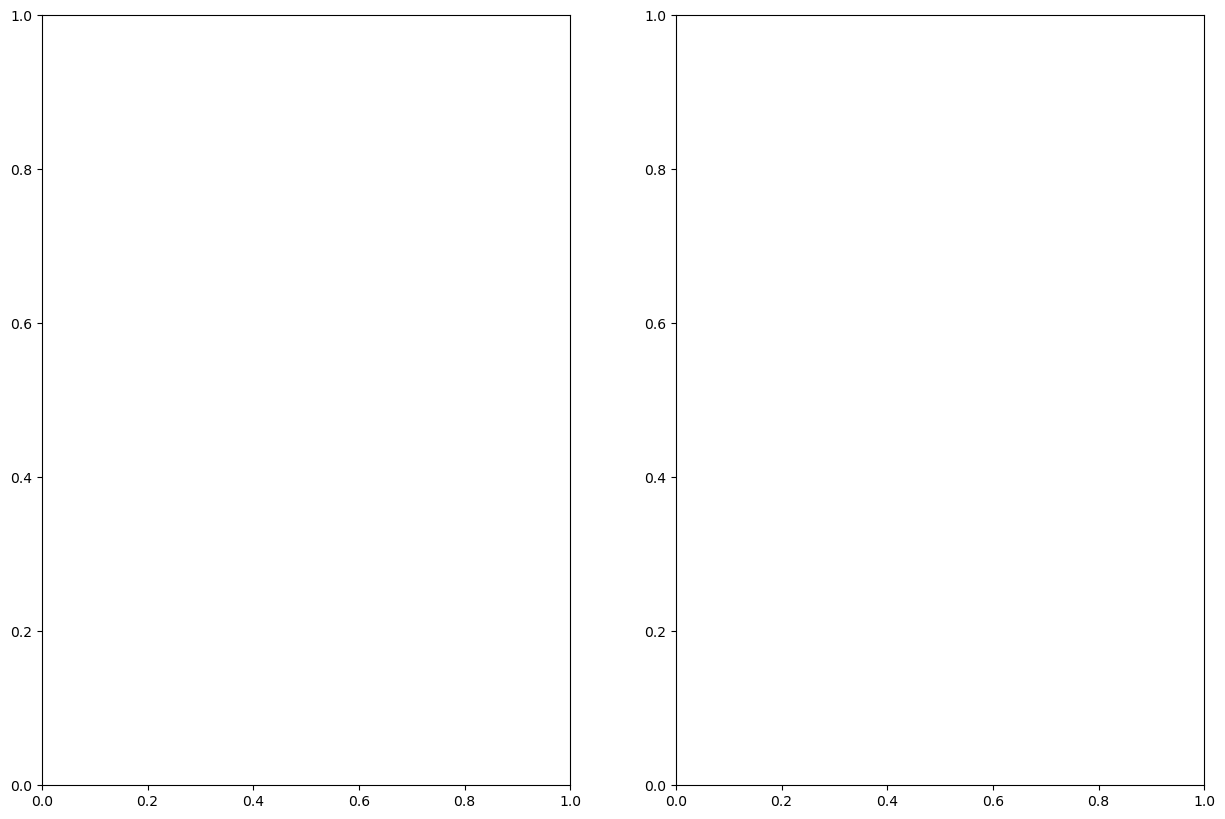

In [12]:
densite_conso_journaliere(donnees_simulees(simulation(1000)))

In [ ]:
simulations=simulation(10)

In [ ]:
simulations_consos=coefvitesse(EMP,simulations)
conso_journees_types=simulations_consos.groupby(['Individu'])['Consommation'].sum().to_frame().apply(lambda x:round(x,3)).rename(columns={'Consommation':'Consommation (kwh)'})
conso_journees_types

In [ ]:
''' Fonction générant un tableau de lois de durée restée dans un lieu selon une base de données'''
def tableau_lois_dureelieu(dataset=EMP):
    emp_df=dataset
    nb_dep_df=emp_df.groupby("IDENT_IND")["num_dep_V"].max().to_frame().rename(columns={"num_dep_V":"nb_dep"})
    emp_df=emp_df.set_index("IDENT_IND")
    emp_df["nb_dep"]=nb_dep_df["nb_dep"]
    emp_df=emp_df.reset_index()

    data=emp_df
    data["Durée"]=0 #On crée une colonne "durée"
    data.loc[data["nb_dep"]==1,"Durée"]=24-data["HEURE_ARRIVEE"]
    data.loc[data["nb_dep"]==data["num_dep_V"],"Durée"]=24-data["HEURE_ARRIVEE"]
    #On remplit la colonne "durée" en faisant la différence entre l'heure du prochain départ de l'individu et l'heure d'arriver à son lieu actuel.
    data.loc[(data["nb_dep"]!=1)&(data["nb_dep"]!=data["num_dep_V"]),'Durée'] = data.groupby('IDENT_IND')["HEURE_DEPART"].shift(-1) - data["HEURE_ARRIVEE"]

    emp_df=data
    # Matin (départ entre 00h et 11h) :
    emp_matin=emp_df[emp_df["HEURE_DEPART"]<=11]
    # Midi (départ entre 11h et 14h) :
    emp_midi=emp_df[(emp_df["HEURE_DEPART"]>11)&( emp_df["HEURE_DEPART"]<=14)]
    # Après-midi (départ entre 14h et 17h) :
    emp_am=emp_df[(emp_df["HEURE_DEPART"]>14)&( emp_df["HEURE_DEPART"]<=17)]
    # Soir (départ entre 17h et 00h) :
    emp_soir=emp_df[(emp_df["HEURE_DEPART"]>17)&( emp_df["HEURE_DEPART"]<=24)]

    dist_names = ['norm','gamma', 'pareto', 't', 'lognorm', 'invgamma', 'invgauss', 'chi2','beta']

    #Matin
    lois_duree_matin=[]

    for lieu in list(set(emp_df["Lieu_Arrivee"])):
        #emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
        '''On cherche la loi qui a la plus petite somme des résidus au carré'''
        data=emp_matin[emp_matin["Lieu_Arrivee"]==lieu]["Durée"].dropna()
        sse = np.inf 
        y, x = np.histogram(data, bins=48, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0

        # Pour chaque distribution
        for name in dist_names:

            # Modéliser
            dist = getattr(stats, name)
            param = dist.fit(data)
        
            # Paramètres
            loc = param[-2]
            if abs(loc)<10**(-2):
                loc=0
            scale = param[-1]
            arg = param[:-2]

            # PDF
            pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
            # SSE
            model_sse = np.sum((y - pdf)**2)

            # Si le SSE est diminué, enregistrer la loi
            if model_sse < sse:
                best_pdf = pdf
                sse = model_sse
                best_loc = loc
                best_scale = scale
                best_arg = arg
                best_param=param
                best_name = name
        lois_duree_matin.append([best_name,best_param])

        #Midi:

        lois_duree_midi=[]

    for lieu in list(set(emp_df["Lieu_Arrivee"])):
        #emp_midi[emp_midi["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
        '''On cherche la loi qui a la plus petite somme des résidus au carré'''
        data=emp_midi[emp_midi["Lieu_Arrivee"]==lieu]["Durée"].dropna()
        sse = np.inf 
        y, x = np.histogram(data, bins=48, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0

        # Pour chaque distribution
        for name in dist_names:

            # Modéliser
            dist = getattr(stats, name)
            param = dist.fit(data)

            # Paramètres
            loc = param[-2]
            scale = param[-1]
            arg = param[:-2]
            if abs(loc)<10**(-2):
                loc=0
            # PDF
            pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
            # SSE
            model_sse = np.sum((y - pdf)**2)

            # Si le SSE est diminué, enregistrer la loi
            if model_sse < sse:
                best_pdf = pdf
                sse = model_sse
                best_loc = loc
                best_scale = scale
                best_arg = arg
                best_param=param
                best_name = name
        lois_duree_midi.append([best_name,best_param]) 

    #Après-midi:
    lois_duree_am=[]

    for lieu in list(set(emp_df["Lieu_Arrivee"])):
        #emp_am[emp_am["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
        '''On cherche la loi qui a la plus petite somme des résidus au carré'''
        data=emp_am[emp_am["Lieu_Arrivee"]==lieu]["Durée"].dropna()
        sse = np.inf 
        y, x = np.histogram(data, bins=48, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0

        # Pour chaque distribution
        for name in dist_names:

            # Modéliser
            dist = getattr(stats, name)
            param = dist.fit(data)

            # Paramètres
            loc = param[-2]
            scale = param[-1]
            arg = param[:-2]
            if abs(loc)<10**(-2):
                loc=0

            # PDF
            pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
            # SSE
            model_sse = np.sum((y - pdf)**2)

            # Si le SSE est diminué, enregistrer la loi
            if model_sse < sse:
                best_pdf = pdf
                sse = model_sse
                best_loc = loc
                best_scale = scale
                best_arg = arg
                best_param=param
                best_name = name
    
        lois_duree_am.append([best_name,best_param])

    #Soir:
    lois_duree_soir=[]

    for lieu in list(set(emp_df["Lieu_Arrivee"])):
        #emp_soir[emp_soir["Lieu_Arrivee"]==lieu]["Durée"].plot.hist(ax=ax[i][j],bins=20,density=True,ylabel='Fréquence',subplots=True,xlabel="Durée passée sur le lieu : "+lieu+" ")
        '''On cherche la loi qui a la plus petite somme des résidus au carré'''
        data=emp_soir[emp_soir["Lieu_Arrivee"]==lieu]["Durée"].dropna()
        sse = np.inf 
        y, x = np.histogram(data, bins=48, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0

        # Pour chaque distribution
        for name in dist_names:

            # Modéliser
            dist = getattr(stats, name)
            param = dist.fit(data)

            # Paramètres
            loc = param[-2]
            scale = param[-1]
            arg = param[:-2]
            if abs(loc)<10**(-2):
                loc=0

            # PDF
            pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
            # SSE
            model_sse = np.sum((y - pdf)**2)

            # Si le SSE est diminué, enregistrer la loi
            if model_sse < sse :
                best_pdf = pdf
                sse = model_sse
                best_loc = loc
                best_scale = scale
                best_arg = arg
                best_param=param
                best_name = name
        lois_duree_soir.append([best_name,best_param])


    #Création du tableau des lois :
    lois_duree_df=pd.DataFrame(index=["Matin","Midi","Après-midi","Soir"],columns=list(set(emp_df["Lieu_Arrivee"])))
    lois_duree_df.loc["Matin"]=lois_duree_matin
    lois_duree_df.loc["Midi"]=lois_duree_midi
    lois_duree_df.loc["Après-midi"]=lois_duree_am
    lois_duree_df.loc["Soir"]=lois_duree_soir
    return lois_duree_df



def duree_lieu(heure_arrivee,lieu_arrivee,dataset=EMP):
    '''Fonction durée restée dans un lieu: prend une heure d'arrivée en format numérique et un lieu,ainsi qu'un dataset et renvoie une durée'''
    i=0
    while i==0:
        if heure_arrivee<=11:
            plage= "Matin"
        elif heure_arrivee<=14:
            plage="Midi"
        elif heure_arrivee<=17:
            plage= "Après-midi"
        else:
            plage= "Soir"
        loi=tableau_lois_dureelieu(dataset).loc[plage,lieu_arrivee]
        dist=loi[0]
        #print(dist)
        param=list(loi[1])
        if abs(param[-2])<10**(-2):
            param[-2]=0
        #print(param)
        sample = getattr(stats,dist).rvs(*param)
        if sample>=0:
            i=1
    return round(sample,2)


In [ ]:
duree_lieu(11,'Entreprise',pd.read_excel("data/data.xlsx"))

In [8]:
# Simulation de 10 000 journées types pour renvoyer la consommation journalière de chaque journée

def donnees_simulees(simulation):
    '''Fonction qui prend une simulation de journées types de déplacements et calcule la consommation éléctrique associée à chaque journée en partant du principe que la consommaton d'une voiture electrique est de 17 kwh/100km'''
    simulations=simulation 
    simulations_consos=coefvitesse(EMP,simulations)
    conso_journees_types=simulations_consos.groupby(['Individu'])['Consommation'].sum().to_frame().apply(lambda x:round(x,3)).rename(columns={'Consommation':'Consommation (kwh)'}) # Renvoie un tableau de la consommation totale sur la journée de l'individu
    return conso_journees_types


def densite_conso_journaliere(donnees_simulees):
    '''Fonction qui prend en entrée une simulation effectuée par la fonction 'donnees_simulees' et renvoie la densité de l'energie consommée pour cette simulation '''
    simulations=donnees_simulees
    fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    EMP_conso= EMP_vitesse.groupby('IDENT_IND')['Consommation (kwh)'].sum().to_frame()
    sns.kdeplot(data=EMP_conso, fill=True, legend=False,ax=ax[1],cut=0)
    sns.kdeplot(data=simulations, fill=True,legend=False, ax=ax[0])
    plt.suptitle("Densité de la consommation journalière d'un individu (kwh)")
    ax[0].set_xlabel('Consommation (kwh)  ,   conso moyenne = '+ str(float(round(simulations.mean(),2)))+' kwh')
    ax[1].set_xlabel('Consommation (kwh)  ,   conso moyenne = '+ str(float(round(EMP_conso.mean(),2)))+' kwh')
    ax[0].set_ylabel('Densité')
    ax[1].set_ylabel('Densité')
    ax[0].set_title("Simulation")
    ax[1].set_title("Données empiriques EMP")
    plt.show()

In [228]:
def densite_conso_temps(simulation,dataset=EMP_vitesse):
    '''Fonction qui prend en argument une simulation effectuée par la fonction "simulation" une base de données EMP avec colonne consommation et renvoie la densité de la consommation par rapport au temps de cette simulation ainsi que de la base de donnée EMP'''
    #Pour simplifier, on suppose la consommation d'un trajet se fait à l'heure d'arrivée (car les trajets sont des trajets courtes distances
    simulation_consos=coefvitesse(EMP,simulation)
    fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    tableau_conso=pd.DataFrame(index=list(np.arange(0,24)))
    tableau_conso['Consommation (kwh)']=0
    df=heures_consommation(simulation_consos)
    for i in tableau_conso.index:
        tableau_conso.loc[i,'Consommation (kwh)']=df.loc[df['Heure']==i]['Consommation (kwh)'].sum()
    total_consommation=tableau_conso['Consommation (kwh)'].sum()
    tableau_conso['Pourcentage simulation'] = (tableau_conso['Consommation (kwh)'] / total_consommation)
    ax[0].plot(tableau_conso.index, tableau_conso['Pourcentage simulation'], marker='o', linestyle='-', color='b')
    ax[0].fill_between(tableau_conso.index, tableau_conso['Pourcentage simulation'], color='b', alpha=0.3)
    tableau_conso2=tableau_conso.drop(['Pourcentage simulation'],axis=1).copy()
    dataset=heures_consommation(dataset)
    for i in tableau_conso2.index:
        tableau_conso2.loc[i,'Consommation (kwh)']=dataset.loc[dataset['Heure']==i]['Consommation (kwh)'].sum()
    total_consommation2=tableau_conso2['Consommation (kwh)'].sum()
    tableau_conso2['Pourcentage EMP'] = (tableau_conso2['Consommation (kwh)'] / total_consommation2)
    ax[1].plot(tableau_conso2.index, tableau_conso2['Pourcentage EMP'], marker='o', linestyle='-', color='b')
    ax[1].fill_between(tableau_conso2.index, tableau_conso2['Pourcentage EMP'], color='b', alpha=0.3)
    ax[0].set_xticks(np.arange(24))
    ax[1].set_xticks(np.arange(24))
    plt.show()
    return pd.concat([tableau_conso.drop(['Consommation (kwh)'],axis=1),tableau_conso2.drop(['Consommation (kwh)'],axis=1)],axis=1)

In [221]:
h=simulation(500)

In [167]:
simulation_consos=coefvitesse(EMP,h)
heures_consommation(simulation_consos)

,INDIVIDU,LIEU_DEPART,TEMPS_ATTENTE,TEMPS_TRAJET,HEURE_DEPART,HEURE_ARRIVEE,LIEU_ARRIVEE,NUMERO_TRAJET,VITESSE_PREDITE,DISTANCE_PREDITE,Consommation (kwh),Heure
0,32,Rue,0.08,0.14,0.08,0.22,Rue,1,27.038722,3.785421,0.643522,0
1,37,Rue,0.18,0.20,0.18,0.38,Rue,1,27.853261,5.570652,0.947011,0
2,24,Domicile,0.11,0.37,0.11,0.48,Parking,1,30.102216,11.137820,1.893429,0
3,25,Rue,0.27,0.30,0.27,0.57,Parking,1,29.198044,8.759413,1.489100,0
4,14,Domicile,0.29,0.28,0.29,0.57,Rue,1,28.935423,8.101918,1.377326,0
...,...,...,...,...,...,...,...,...,...,...,...,...
220,6,Rue,1.64,2.45,21.27,23.72,Rue,4,61.289236,150.158628,25.526967,23
221,44,Rue,1.18,0.13,23.69,23.82,Domicile,3,30.841795,4.009433,0.681604,23
222,10,Domicile,9.62,0.10,23.79,23.89,Rue,3,30.459532,3.045953,0.517812,23
223,26,Rue,0.09,0.22,23.68,23.90,Rue,6,32.036929,7.048124,1.198181,23


/tmp/ipykernel_374/3093491632.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '98.48468822830799' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tableau_conso.loc[i,'Consommation (kwh)']=df.loc[df['Heure']==i]['Consommation (kwh)'].sum()


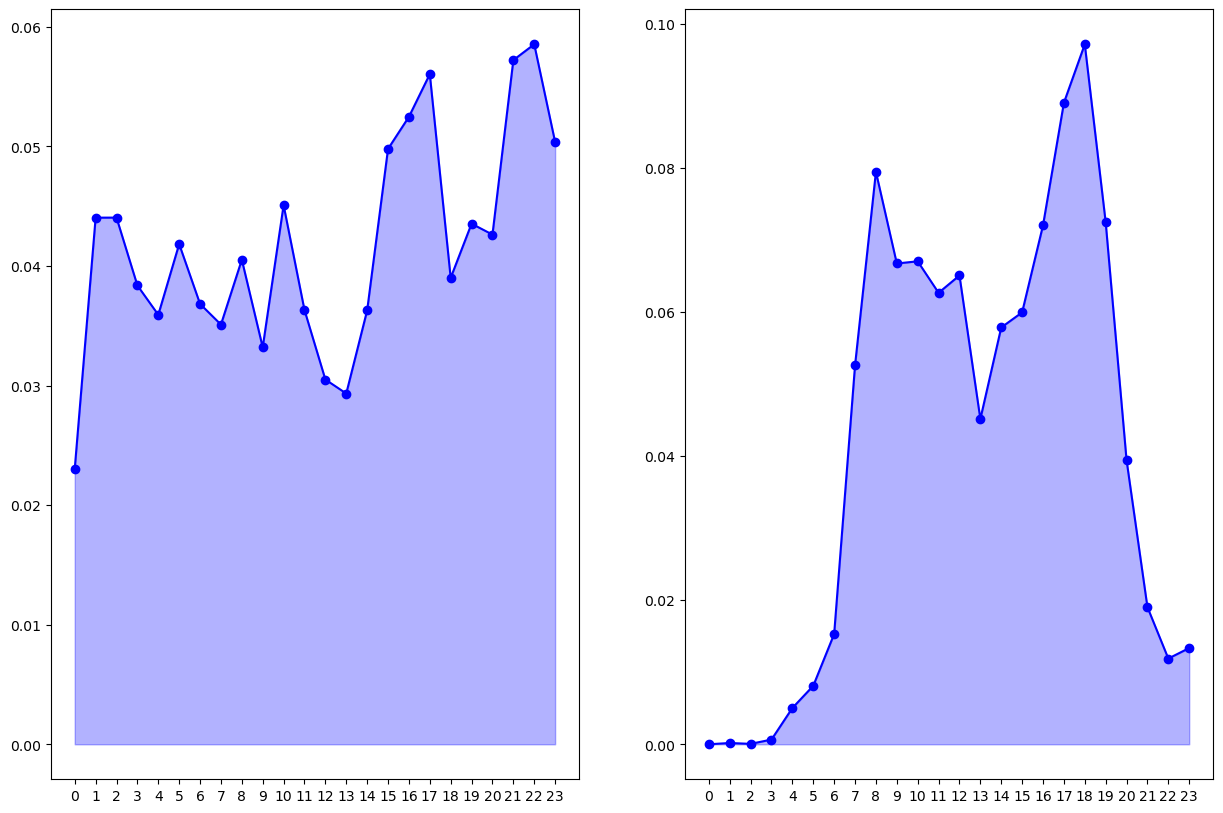

,Pourcentage simulation,Pourcentage EMP
0,0.023047,0.000000
1,0.044039,0.000178
2,0.044044,0.000059
3,0.038369,0.000655
4,0.035917,0.005033
5,0.041832,0.008115
6,0.036826,0.015299
7,0.035100,0.052580
8,0.040522,0.079435
9,0.033198,0.066715


In [229]:
densite_conso_temps(h)

In [18]:
import seaborn as sns

In [158]:
heures_consommation(coefvitesse(EMP,h))

,INDIVIDU,LIEU_DEPART,TEMPS_ATTENTE,TEMPS_TRAJET,HEURE_DEPART,HEURE_ARRIVEE,LIEU_ARRIVEE,NUMERO_TRAJET,VITESSE_PREDITE,DISTANCE_PREDITE,CONSOMMATION,Heure
0,32,Rue,0.08,0.14,0.08,0.22,Rue,1,27.038722,3.785421,0.643522,0
1,37,Rue,0.18,0.20,0.18,0.38,Rue,1,27.853261,5.570652,0.947011,0
2,24,Domicile,0.11,0.37,0.11,0.48,Parking,1,30.102216,11.137820,1.893429,0
3,25,Rue,0.27,0.30,0.27,0.57,Parking,1,29.198044,8.759413,1.489100,0
4,14,Domicile,0.29,0.28,0.29,0.57,Rue,1,28.935423,8.101918,1.377326,0
...,...,...,...,...,...,...,...,...,...,...,...,...
220,6,Rue,1.64,2.45,21.27,23.72,Rue,4,61.289236,150.158628,25.526967,23
221,44,Rue,1.18,0.13,23.69,23.82,Domicile,3,30.841795,4.009433,0.681604,23
222,10,Domicile,9.62,0.10,23.79,23.89,Rue,3,30.459532,3.045953,0.517812,23
223,26,Rue,0.09,0.22,23.68,23.90,Rue,6,32.036929,7.048124,1.198181,23


In [166]:
def heures_consommation(dataset):
    '''Prend en argument un dataset avec colonne consommation et regroupe par individu et tranche horaire la consommation'''
    dataset=dataset.rename(columns=lambda x: x.upper())
    dataset['Heure'] = dataset['HEURE_ARRIVEE'].astype(int)
    colonne_conso= [colonne for colonne in dataset.columns if colonne.startswith('CONSOMMATION')]
    dataset=dataset.rename(columns={colonne_conso[0]:'Consommation (kwh)' })
    return dataset

In [154]:
[colonne for colonne in coefvitesse(EMP,h).columns if colonne.startswith('Consommation')]

['Consommation']

In [111]:
len(list(np.zeros(24)))

24

In [93]:
int(12.86)

12

In [101]:
heures=pd.DataFrame(index=np.arange(0,24),columns=['Consommation (kwh)'])
heures.index.name='Heure'
heures

,Consommation (kwh)
Heure,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
